In [3]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine

In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
wine = load_wine()
features = 13

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :features], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [6]:
def train(X_train, y_train, wine_net, loss, optimizer, X_test, y_test, batch_size = 100, max_epoch=2000):
    quality, epoch_lst = [], []
    
    epoch = 0
    while epoch < max_epoch:
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = wine_net.forward(x_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        if epoch % 100 == 0:
            test_preds = wine_net.forward(X_test)
            test_preds = test_preds.argmax(dim=1)
            quality.append((test_preds == y_test).float().mean().numpy())
            epoch_lst.append(epoch)
        
        epoch += 1
        
    return quality, epoch_lst

## Dependence of quality rate on number of epoch

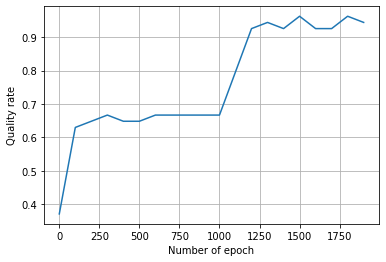

In [7]:
n_input = 13
n_hidden = 13
loss = torch.nn.CrossEntropyLoss()
wine_n = WineNet(n_input, n_hidden)
optimizer = torch.optim.Adam(wine_n.parameters(), lr=1.0e-3)
quality, epoch_lst = train(X_train, y_train, wine_n, loss, optimizer, X_test, y_test)

n_fig = 1
plt.figure(n_fig)
plt.plot(epoch_lst, quality)
plt.xlabel("Number of epoch")
plt.ylabel("Quality rate")
plt.grid()
plt.show()

## The research of dependency of quality rate on number of hidden neurons 

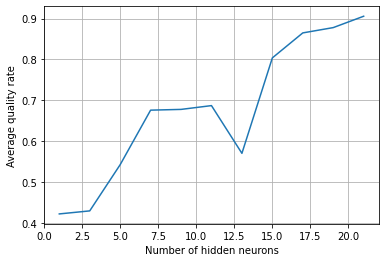

In [9]:
n_input = 13
loss = torch.nn.CrossEntropyLoss()
min_neurons, max_neurons, step_neurons = 1, 22, 2
quality_lst= []
hidden = list(range(min_neurons, max_neurons, step_neurons))
max_reps = 10

for n_hidden in hidden:
    avg_quality = 0
    for rep in range(max_reps):
        net = WineNet(n_input, n_hidden)
        optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
        quality, _ = train(X_train, y_train, net, loss, optimizer, X_test, y_test)
        avg_quality += quality[-1]
    
    quality_lst.append(avg_quality / max_reps)
   

n_fig += 1
plt.figure(n_fig)
plt.plot(hidden, quality_lst)
plt.xlabel("Number of hidden neurons")
plt.ylabel("Average quality rate")
plt.grid()
plt.show()

## The research of dependency of quality rate on size of test dataset

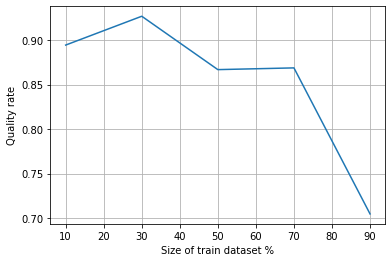

In [13]:
features = 13

n_input = 13
n_hidden = 20
loss = torch.nn.CrossEntropyLoss()
quality_lst = []
size_of_train = list(range(1, 10, 2))
max_reps = 20

for t_size in size_of_train:
    avg_quality = 0
    for rep in range(max_reps):
        perc = t_size / 10
        X_train, X_test, y_train, y_test = train_test_split(
            wine.data[:, :features], 
            wine.target, 
            test_size=perc, 
            shuffle=True)

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.LongTensor(y_train)
        y_test = torch.LongTensor(y_test)

        wine_n = WineNet(n_input, n_hidden)
        optimizer = torch.optim.Adam(wine_n.parameters(), lr=1.0e-3)
        quality, _ = train(X_train, y_train, wine_n, loss, optimizer, X_test, y_test, max_epoch=2000)
        avg_quality += quality[-1]

    quality_lst.append(avg_quality / max_reps)


n_fig += 1
plt.figure(n_fig)
plt.plot(list(map(lambda x: x * 10, size_of_train)), quality_lst)
plt.xlabel("Size of train dataset %")
plt.ylabel("Quality rate")
plt.grid()
plt.show()

## The dependence of the time of the epoch on the batch size

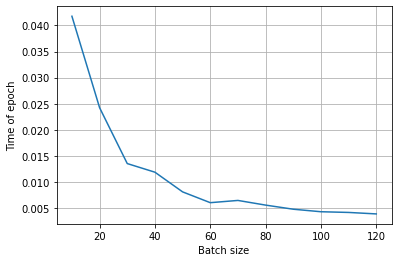

In [16]:
import time 

wine = load_wine()
features = 13

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :features], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


n_input = 13
n_hidden = 13
loss = torch.nn.CrossEntropyLoss()
wine_n = WineNet(n_input, n_hidden)
optimizer = torch.optim.Adam(wine_n.parameters(), lr=1.0e-3)

lst_of_time = []
batch_size_lst = list(range(10, len(X_train), 10))
for b_size in batch_size_lst:
    t = time.time()
    train(X_train, y_train, wine_n, loss, optimizer, X_test, y_test, batch_size=b_size, max_epoch=1)
    lst_of_time.append(time.time() - t)
    

n_fig += 1
plt.figure(n_fig)
plt.plot(batch_size_lst, lst_of_time)
plt.xlabel("Batch size")
plt.ylabel("Time of epoch")
plt.grid()
plt.show()